In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import boutdata
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *



%load_ext autoreload
%autoreload 2

# 2D

In [5]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )
casestore = {}

toload = [
    # dict(name="base", id="frec2_base_nofrec", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    dict(name="base", id="frec3_all_frec", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
]

for case in toload:
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                            unnormalise_geom = case["unnormalise_geom"])

CHECK: Total domain volume is 1.607E+00 [m3]


## Ylow target

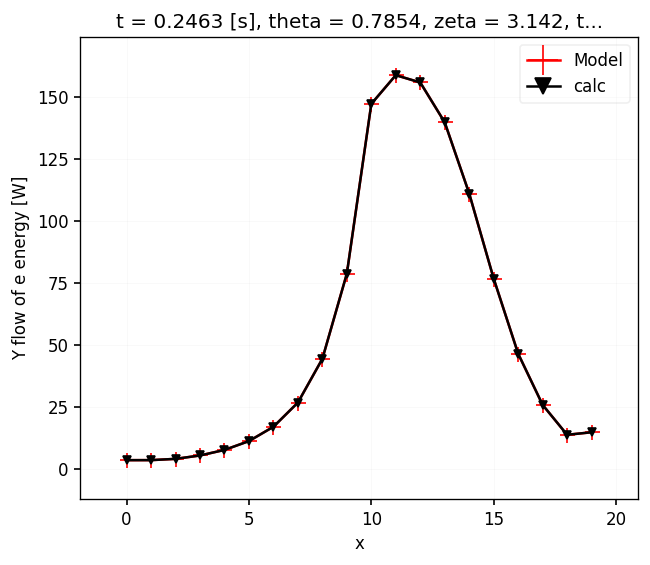

In [4]:
ds = casestore["base"].ds 
if "t" in ds.dims.keys():
    ds = ds.isel(t=-1)
    
Mi = constants("mass_p") *2
q_e = constants("q_e")

i = 2
g = 1

m = ds.metadata

N = ds["Nd+"].values
T = ds["Td+"].values 
V = ds["Vd+"].values 
J = ds["J"].values 
g_22 = ds["g_22"].values
dy = ds["dy"].values  
dx = ds["dx"].values
dz = ds["dz"].values


target_multiplier = 0.95
fast_recycle_fraction = 0.5
fast_recycle_energy_factor = 0.5
target_energy = 3.0 * constants("q_e")


pflux = 0.5 * (N[:,i] + N[:,g])*0.5 * (V[:,i] + V[:,g])
pflow = abs(target_multiplier * pflux * (J[:,i] + J[:,g]) / (np.sqrt(g_22[:,i]) + np.sqrt(g_22[:,g])) * dx[:,i] * dz[:,i])

ion_heatflow = abs(ds["EnergyFlow_d+_ylow"][:,i])

fast_bit = ion_heatflow * target_multiplier * fast_recycle_energy_factor * fast_recycle_fraction 
thermal_bit = pflow * (1-fast_recycle_fraction) * target_energy
neutral_heatflow = fast_bit + thermal_bit


sim_result = ds["Ed_target_recycle"].isel(theta=i) * ds["dv"].isel(theta=i)

(sim_result).plot(label = "Model", marker = "+", ms = 9, c = "red")
neutral_heatflow.plot(marker = "v", ms = 5, c = "k", label = "calc")
plt.legend()
# plt.yscale("log")

## yup target

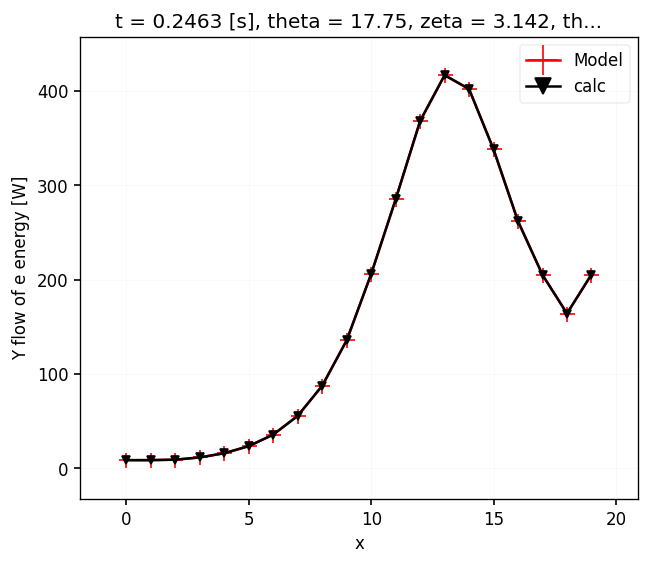

In [6]:
ds = casestore["base"].ds 
if "t" in ds.dims.keys():
    ds = ds.isel(t=-1)
    
Mi = constants("mass_p") *2
q_e = constants("q_e")

i = -3
g = -2

m = ds.metadata

N = ds["Nd+"].values
T = ds["Td+"].values 
V = ds["Vd+"].values 
J = ds["J"].values 
g_22 = ds["g_22"].values
dy = ds["dy"].values  
dx = ds["dx"].values
dz = ds["dz"].values


target_multiplier = 0.95
fast_recycle_fraction = 0.5
fast_recycle_energy_factor = 0.5
target_energy = 3.0 * constants("q_e")


pflux = 0.5 * (N[:,i] + N[:,g])*0.5 * (V[:,i] + V[:,g])
pflow = target_multiplier * pflux * (J[:,i] + J[:,g]) / (np.sqrt(g_22[:,i]) + np.sqrt(g_22[:,g])) * dx[:,i] * dz[:,i]

ion_heatflow = ds["EnergyFlow_d+_ylow"][:,g]

fast_bit = ion_heatflow * target_multiplier * fast_recycle_energy_factor * fast_recycle_fraction 
thermal_bit = pflow * (1-fast_recycle_fraction) * target_energy
neutral_heatflow = fast_bit + thermal_bit


sim_result = ds["Ed_target_recycle"].isel(theta=i) * ds["dv"].isel(theta=i)

(sim_result).plot(label = "Model", marker = "+", ms = 9, c = "red")
neutral_heatflow.plot(marker = "v", ms = 5, c = "k", label = "calc")
plt.legend()
# plt.yscale("log")

## SOL

### Particles

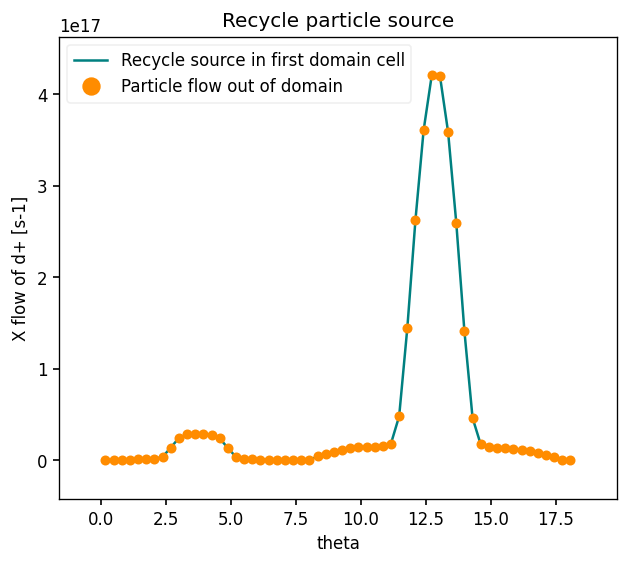

In [8]:
ds = casestore["base"].ds#.isel(t=-1)

sol_multiplier = 0.01

(ds["Sd_wall_recycle"].isel(x=-3)  * ds["dv"].isel(x=-3)).plot(label = "Recycle source in first domain cell")
(ds["ParticleFlow_d+_xlow"].isel(x=-2)*sol_multiplier).plot(label = "Particle flow out of domain", lw = 0, marker = "o", ms = 5)
plt.legend()
plt.title("Recycle particle source")
plt.grid()
# ds["Sd_target_recycle"].isel(x=-3).plot()

### Energy

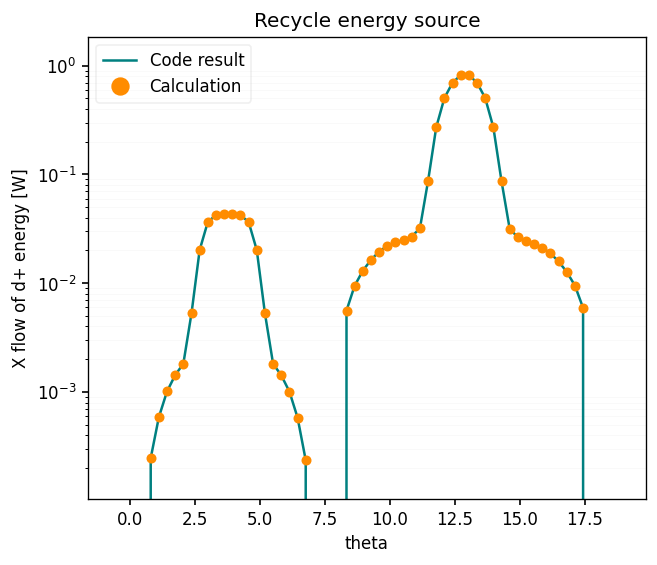

In [9]:
ds = casestore["base"].ds 
if "t" in ds.dims.keys():
    ds = ds.isel(t=-1)
    

sol_multiplier = 0.01
sol_fast_recycle_energy_factor = 0.6
sol_fast_recycle_fraction = 1

sol_energy = 3 * constants("q_e")

ion_particleflow = ds["ParticleFlow_d+_xlow"].isel(x=-2)
ion_heatflow = ds["EnergyFlow_d+_xlow"].isel(x=-2)

fast_bit = ion_heatflow * sol_multiplier * sol_fast_recycle_fraction * sol_fast_recycle_energy_factor 
thermal_bit = ion_particleflow * sol_multiplier * (1-sol_fast_recycle_fraction) * sol_energy
neutral_heatflow = fast_bit + thermal_bit


(ds["Ed_wall_recycle"].isel(x=-3)  * ds["dv"].isel(x=-3)).plot(label = "Code result")
(neutral_heatflow).plot(label = "Calculation", lw = 0, marker = "o", ms = 5)
# (thermal_bit).plot(label = "Expected thermal", lw = 0, marker = "o", ms = 3)
# (fast_bit).plot(label = "Expected fast", lw = 0, marker = "o", ms = 3)
plt.legend()
plt.title("Recycle energy source")
plt.grid()
plt.yscale("log")
# ds["Sd_target_recycle"].isel(x=-3).plot()

## PFR

### Particle flow

Total PFR ion particle flux: -1.341e+19
Total PFR recycle source: 1.341e+19


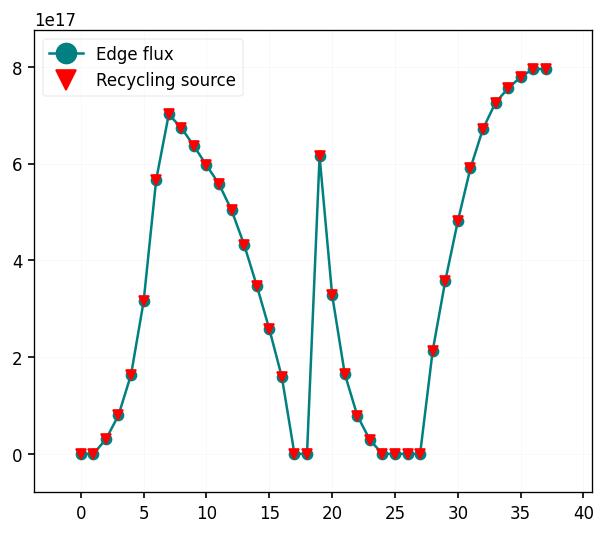

In [10]:
fluxes = []
sources = []
tflux_ions = 0
tflux_recycle = 0

pfr_recycle_multiplier = 0.75

for name in ["lower_pfr_edge", "upper_pfr_edge"]:
    pfr_edge = ds.hermesm.select_region(name)
    fluxes.append((pfr_edge["ParticleFlow_d+_xlow"] * -1 * pfr_recycle_multiplier).squeeze().values)
    sources.append((pfr_edge["Sd_wall_recycle"] * ds["dv"]).squeeze().values)
    
    tflux_ions += (pfr_edge["ParticleFlow_d+_xlow"] * pfr_recycle_multiplier).values.sum()
    tflux_recycle += (pfr_edge["Sd_wall_recycle"]  * pfr_edge["dv"]).values.sum()
    
print(f"Total PFR ion particle flux: {tflux_ions:.3e}")
print(f"Total PFR recycle source: {tflux_recycle:.3e}")
fluxes = np.concatenate(fluxes)
sources = np.concatenate(sources)

fig, ax = plt.subplots()
ax.plot(fluxes, marker = "o", label = "Edge flux")
ax.plot(sources, lw = 0, marker = "v", label = "Recycling source", c = "r")
ax.legend()
# (ds["ParticleFlow_d+_xlow"].isel(x=2) * nfluxnorm * -1).plot(label = "L flow in inner guard cell into domain", lw = 0, marker = "o", ms = 5)
# plt.legend()
# plt.title("Recycle particle source")
# plt.grid()
# # ds["Sd_target_recycle"].isel(x=-3).plot()

### Heat flow
- Note that I got lazy and here I plot the core as well which goes negative

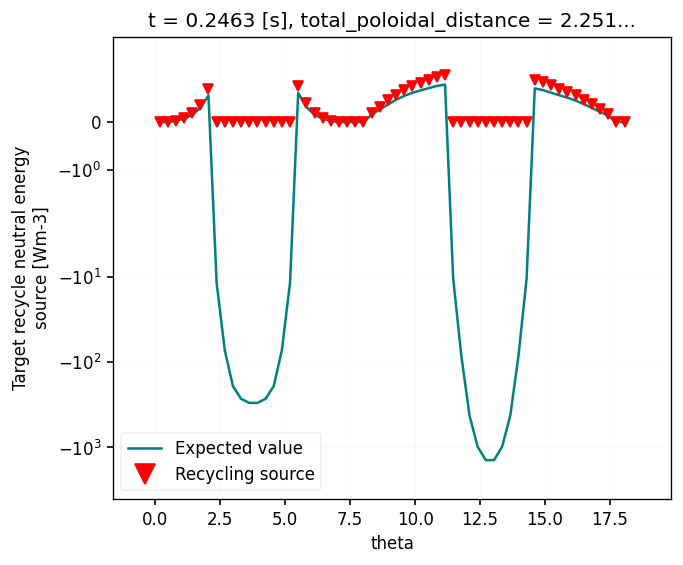

In [7]:
ds = casestore["base"].ds 
if "t" in ds.dims.keys():
    ds = ds.isel(t=-1)
    


pfr_multiplier = 0.75
pfr_fast_recycle_energy_factor = 0.6
pfr_fast_recycle_fraction = 0.5
pfr_energy = 3 * constants("q_e")


fluxes = []
sources = []
tflux_ions = 0
tflux_recycle = 0

ion_particleflow = ds["ParticleFlow_d+_xlow"].isel(x=2) * -1
ion_heatflow = ds["EnergyFlow_d+_xlow"].isel(x=2) * -1

fast_bit = ion_heatflow * sol_multiplier * sol_fast_recycle_fraction * sol_fast_recycle_energy_factor 
thermal_bit = ion_particleflow * sol_multiplier * (1-sol_fast_recycle_fraction) * sol_energy
neutral_heatflow = fast_bit + thermal_bit

sim_result = ds["Ed_wall_recycle"].isel(x=2) * ds["dv"].isel(x=2)

fig, ax = plt.subplots()
neutral_heatflow.plot(ax = ax, label = "Expected value")
sim_result.plot(ax = ax, lw = 0, marker = "v", label = "Recycling source", c = "r")
ax.legend()
ax.set_yscale("symlog")

# (ds["ParticleFlow_d+_xlow"].isel(x=2) * nfluxnorm * -1).plot(label = "L flow in inner guard cell into domain", lw = 0, marker = "o", ms = 5)
# plt.legend()
# plt.title("Recycle particle source")
# plt.grid()
# # ds["Sd_target_recycle"].isel(x=-3).plot()

## ylow target

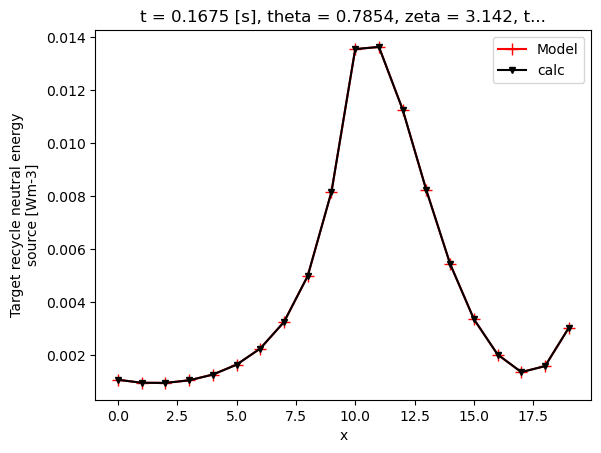

In [ ]:
ds = casestore["base"].ds
Mi = 2
q_e = 1

i = 2
g = 1

m = ds.metadata

N = ds["Nd+"].values / m["Nnorm"]
T = ds["Td+"].values / m["Tnorm"]
V = ds["Vd+"].values / m["Cs0"]
J = ds["J"].values / (m["rho_s0"] * m["Bnorm"])
g_22 = ds["g_22"].values / (m["rho_s0"] * m["rho_s0"])
dy = ds["dy"].values  

target_multiplier = 0.95
fast_recycle_fraction = 0.8
fast_recycle_energy_factor = 0.75
target_energy = 3.0 / m["Tnorm"]

flux = -0.5 * (N[:,i] + N[:,g])*0.5 * (V[:,i] + V[:,g])
flow = target_multiplier * flux * (J[:,i] + J[:,g]) / (np.sqrt(g_22[:,i]) + np.sqrt(g_22[:,g]))

tisheath = (T[:,i] + T[:,g]) / 2
neutral_energy = flow * (
    fast_recycle_energy_factor * fast_recycle_fraction * tisheath + (1-fast_recycle_fraction) * target_energy)
neutral_energy /= (J[:,i] * dy[:,i])

calc = neutral_energy

norm = constants("q_e") * m["Nnorm"] * m["Tnorm"] * m["Omega_ci"]
(ds["Ed_target_recycle"].isel(theta=i)/norm).plot(label = "Model", marker = "+", ms = 9, c = "red")
plt.plot(ds.isel(theta=i)["x"], calc, marker = "v", ms = 5, c = "k", label = "calc")
plt.legend()
# plt.yscale("symlog")

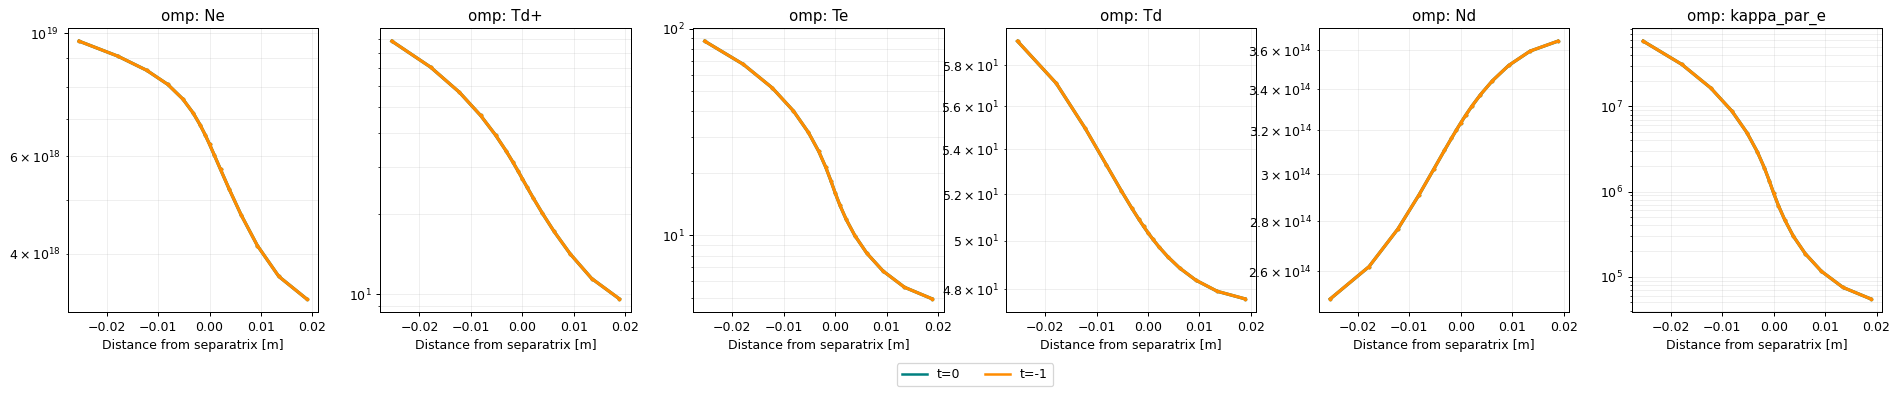

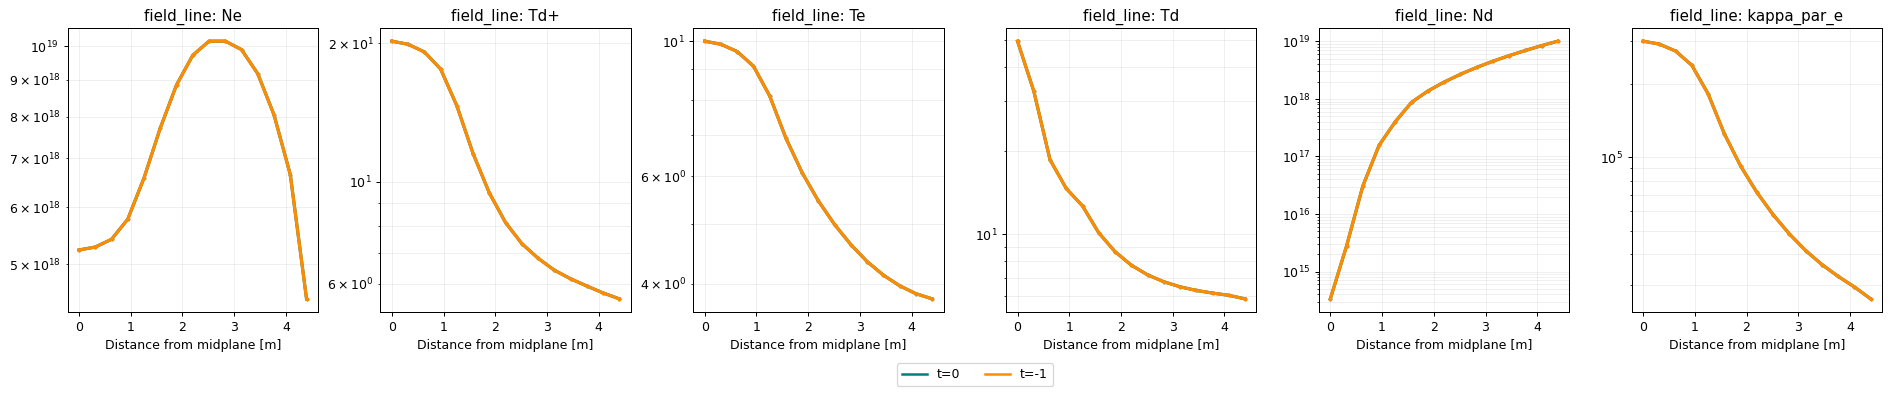

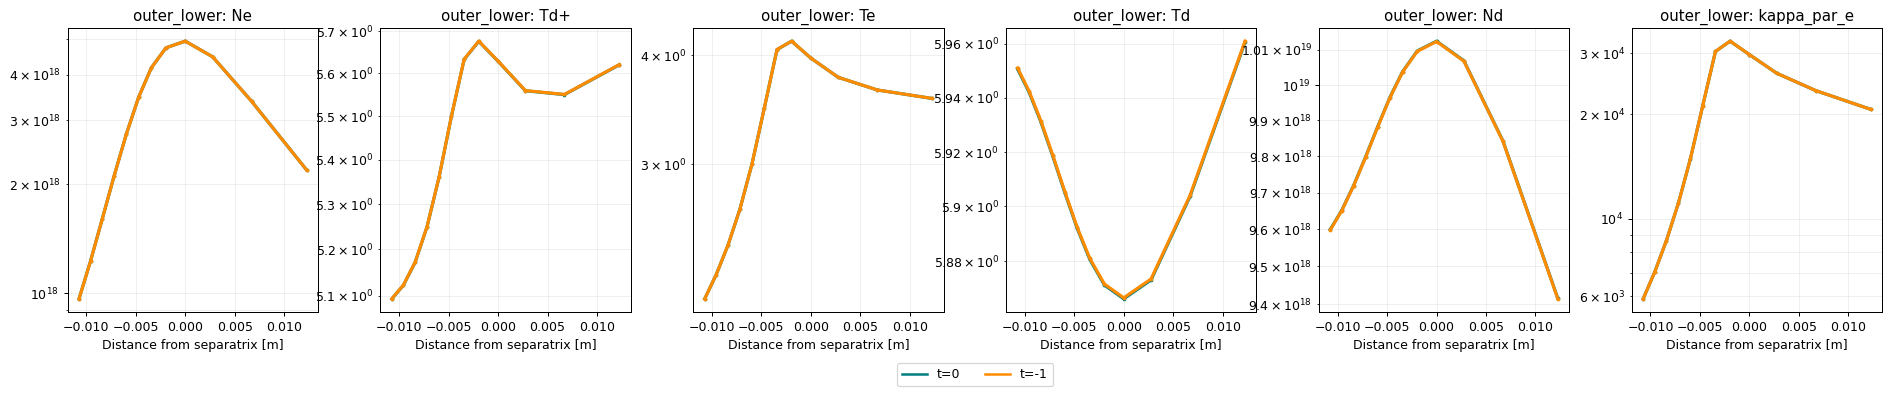

In [ ]:
cases = dict()

cases["t=0"] = casestore["base"].ds.isel(t=0, x = slice(2,-2))
cases["t=-1"] = casestore["base"].ds.isel(t=-1, x = slice(2,-2))

lineplot(
    cases = cases,
    clean_guards = False,
    regions = ["omp", "field_line", "outer_lower"],
    params = ["Ne", "Td+", "Te", "Td", "Nd", "kappa_par_e"],
    # params = ["Pd+", "Pe", "Pd", "NVd+", "NVd"],
    dpi = 90
)

# 1D

In [ ]:
cases = {}
cases["frecon"] = Load.case_1D(r"/ssd_scratch/hcases/fastrec/1d/fr1d_3_sheathdiags", guard_replace = False).ds
cases["frecoff"] = Load.case_1D(r"/ssd_scratch/hcases/fastrec/1d/fr1d_4_nofrec", guard_replace = False, squeeze = True).ds
# cases["sheathtest"] = Load.case_1D(r"/ssd_scratch/hcases/fastrec/1d/fr1d_5_sheath_hbalance_test", guard_replace = False).ds

## Normalised sheath test

In [ ]:
ds = cases["frecon"]
if "t" in ds.dims.keys():
  ds = ds.isel(t=-1)

m = ds.metadata

# q_e = constants("q_e")
# Mi = constants("mass_p")*2

q_e = 1
Mi = 2

Ne = ds["Ne"].values / m["Nnorm"]
Ti = ds["Td+"].values / m["Tnorm"]
Te = ds["Te"].values / m["Tnorm"]
Pi = ds["Pd+"].values / (q_e * m["Nnorm"] * m["Tnorm"])
g_22 = ds["g_22"].values / (m["rho_s0"]**2)
J = ds["J"].values / (m["rho_s0"] / m["Bnorm"])
dy = ds["dy"].values
dx = ds["dx"].values / ds["dx"].attrs["conversion"]
dz = ds["dz"].values 

Pnorm = m["Nnorm"] * m["Tnorm"] * constants("q_e")
powernorm = m["rho_s0"] * m["rho_s0"]**2 * Pnorm * m["Omega_ci"]
# powernorm = 1

def limitFree(fm, fc):
  if (fm < fc):
    return fc
  if (fm < 1e-10):
    return fc
  fp = fc**2 / fm
  return fp

i = -3
im = -4
ip = -2


Neip = limitFree(Ne[im], Ne[i])
Tiip = limitFree(Ti[im], Ti[i])
Teip = limitFree(Te[im], Te[i])

nisheath = 0.5 * (Neip + Ne[i])
tisheath = 0.5 * (Tiip + Ti[i])
tesheath = 0.5 * (Te[ip] + Te[i])
C_i_sq = (1 * q_e * tisheath+tesheath) / Mi
visheath = np.sqrt(C_i_sq)

q = (2.5 * tisheath * q_e) * nisheath * visheath   # W/m^2
hflow = q * (J[i] + J[im]) / (np.sqrt(g_22[i]) + np.sqrt(g_22[im])) * (0.5*(dx[i] + dx[im]) * 0.5*(dz[i] + dz[im]))  # [W]

pflow = nisheath * visheath * (J[i] + J[im]) / (np.sqrt(g_22[i]) + np.sqrt(g_22[im])) * (0.5*(dx[i] + dx[im]) * 0.5*(dz[i] + dz[im]))  # [s-1]

target_fast_recycle_energy_factor = 1
target_fast_recycle_fraction = 1

neutral_energy = hflow * target_fast_recycle_energy_factor * target_fast_recycle_fraction

source = hflow / (J[i] * dx[i] * dy[i] * dz[i])



print("NORMALISED UNITS")
print("### Sheath ion heat flow")
print("Simulation: ", ds["EnergyFlow_d+_ylow"].isel(pos=-2).values / powernorm)
print("Calculation:", hflow)

print("\nSI UNITS")
print("Simulation: ", ds["EnergyFlow_d+_ylow"].isel(pos=-2).values * 1e-6)
# fig, ax = plt.subplots()
# (ds["EnergyFlow_d+_ylow"]).plot(ax = ax, marker = "o")
# ax.set_xlim(9.5,10.2)


NORMALISED UNITS
### Sheath ion heat flow
Simulation:  473925277.04136163
Calculation: 473925277.04136163

SI UNITS
Simulation:  43.887308150942395


## Heat balance

In
-----
Ion source                 50.265
Electron source            50.265
Recycled neutrals          0.318

Out
-----
Excitation radiation      -10.054
Recombination radiation   -0.000
Ion sheath loss           -31.791
Electron sheath loss      -34.746
Neutral reflection        -0.340

Total
-----
Total in:                  100.849 [MW]
Total out                 -76.931 [MW]
Imbalance:                 23.918 [MW]  /  23.72%


Text(0.5, 0, 'Time [s]')

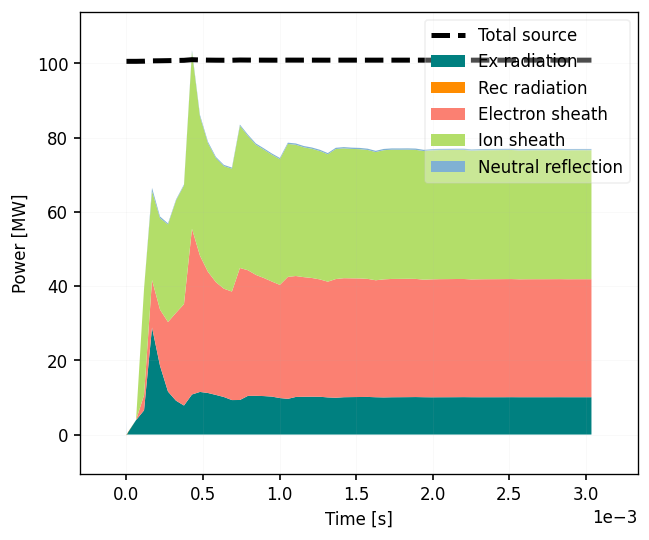

In [ ]:
# ds = cases["frecoff"]
ds = cases["frecon"]


"""
Calculates heat balance for 1D case
You MUST provide a dataset without guard replacement
"""

domain = ds.isel(pos = slice(2,-2))
radex = (domain["Rd+_ex"] * domain["dv"]).sum("pos").values*1e-6 if "Rd+_ex" in ds.data_vars else np.zeros_like(ds["t"])
radrec = (domain["Rd+_rec"] * domain["dv"]).sum("pos").values*1e-6 if "Rd+_rec" in ds.data_vars else np.zeros_like(ds["t"])
isrc = (domain["Pd+_src"] * domain["dv"] * 3/2).sum("pos").values*1e-6
esrc = (domain["Pe_src"] * domain["dv"] * 3/2).sum("pos").values*1e-6
nrefl = (domain["Ed_target_refl"] * domain["dv"]).sum("pos").values*1e-6 if "Ed_target_refl" in ds.data_vars else np.zeros_like(ds["t"])
nrec = (domain["Ed_target_recycle"] * domain["dv"]).sum("pos").values*1e-6 if "Ed_target_recycle" in ds.data_vars else np.zeros_like(ds["t"])

def wall(param):
    return (ds[param].isel(pos = -2) + ds[param].isel(pos = -3)) * 0.5

q_e = constants("q_e")
Mi = constants("mass_p")*2

da =  (wall("J") / np.sqrt(wall("g_22"))) * (wall("dx") * wall("dz"))
pflux = wall("Ne") * wall("Vd+") * float(da)
isheath = -(2.5 * wall("Td+")*q_e) * pflux * 1e-6
esheath = -(4.5 * wall("Te")*q_e) * pflux * 1e-6

total_in = isrc[-1]+esrc[-1]+nrec[-1]
total_out = radex[-1]+radrec[-1]+isheath[-1]+esheath[-1]+nrefl[-1]
imbalance = total_in + total_out
imbalance_ratio = imbalance/total_in

print("In")
print("-----")

print(f"Ion source                 {isrc[-1]:.3f}")
print(f"Electron source            {esrc[-1]:.3f}")
print(f"Recycled neutrals          {nrec[-1]:.3f}")

print("\nOut")
print("-----")

print(f"Excitation radiation      {radex[-1]:.3f}")
print(f"Recombination radiation   {radrec[-1]:.3f}")
print(f"Ion sheath loss           {isheath[-1]:.3f}")
print(f"Electron sheath loss      {esheath[-1]:.3f}")
print(f"Neutral reflection        {nrefl[-1]:.3f}")

print("\nTotal")
print("-----")

print(f"Total in:                  {total_in:.3f} [MW]")
print(f"Total out                 {total_out:.3f} [MW]")
print(f"Imbalance:                 {imbalance:.3f} [MW]  /  {imbalance_ratio:.2%}")

fig, ax = plt.subplots()

ax.plot(ds["t"], isrc+esrc+nrec, label = "Total source", lw = 3, ls = "--", c = "k")

ax.stackplot(ds["t"], [-radex, -radrec, -isheath, -esheath, -nrefl], 
             labels = ["Ex radiation", "Rec radiation", "Electron sheath", "Ion sheath", "Neutral reflection", "Recycled neutrals"], 
             antialiaseds = True)

ax.legend(loc="upper right")
ax.set_ylabel("Power [MW]")
ax.set_xlabel("Time [s]")

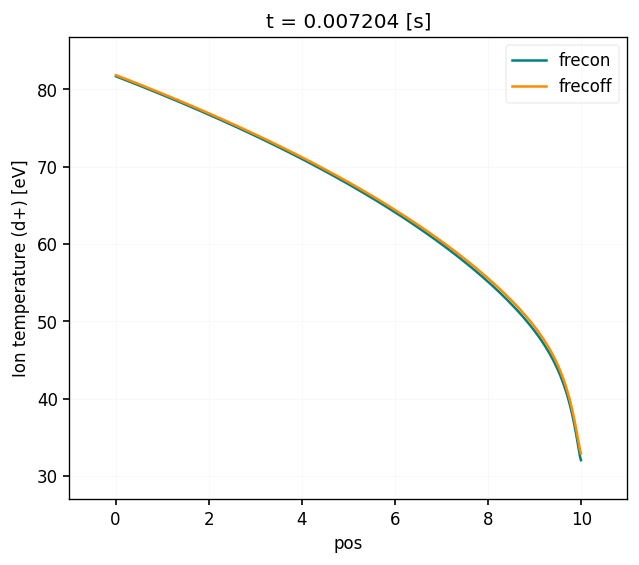

In [ ]:
fig, ax = plt.subplots()

for case in ["frecon", "frecoff"]:
    cases[case]["Td+"].isel(pos = slice(2,-2), t = -1).plot(label = case)
    
ax.legend()

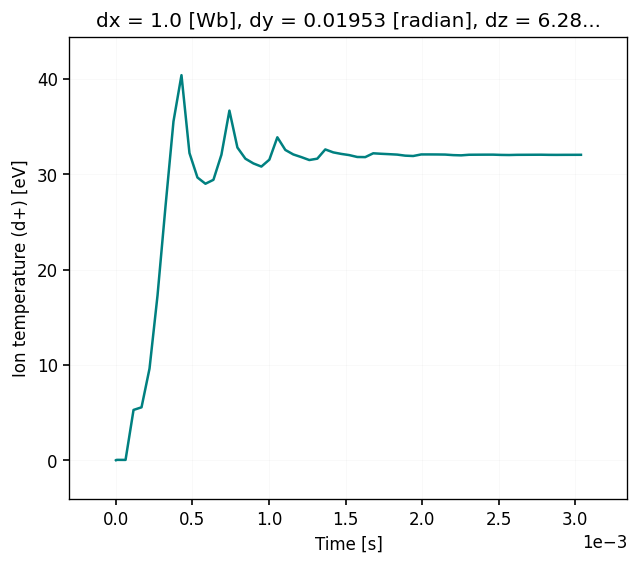

In [ ]:
cases["frecon"]["Td+"].isel(pos = -3).plot()

In
-----
Ion source                 50.265
Electron source            50.265
Recycled neutrals          0.000

Out
-----
Excitation radiation      -0.075
Recombination radiation   0.148
Ion sheath loss           -0.000
Electron sheath loss      -0.000
Neutral reflection        -0.001

Total
-----
Total in:                  100.531 [MW]
Total out                 0.073 [MW]
Imbalance:                 100.604 [MW]  /  100.07%


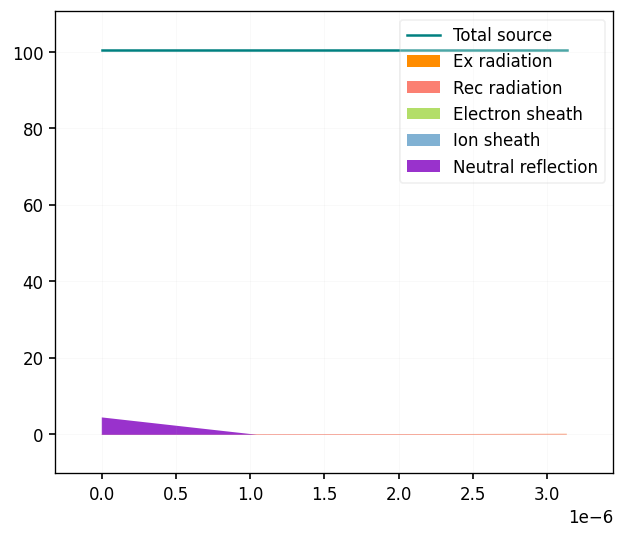

In [ ]:
def heat_balance_1d(ds):
    """
    Calculates heat balance for 1D case
    You MUST provide a dataset without guard replacement
    """

    domain = ds.isel(pos = slice(2,-2))
    radex = (domain["Rd+_ex"] * domain["dv"]).sum("pos").values*1e-6 if "Rd+_ex" in ds.data_vars else np.zeros_like(ds["t"])
    radrec = (domain["Rd+_rec"] * domain["dv"]).sum("pos").values*1e-6 if "Rd+_rec" in ds.data_vars else np.zeros_like(ds["t"])
    isrc = (domain["Pd+_src"] * domain["dv"] * 3/2).sum("pos").values*1e-6
    esrc = (domain["Pe_src"] * domain["dv"] * 3/2).sum("pos").values*1e-6
    nrefl = (domain["Ed_target_refl"] * domain["dv"]).sum("pos").values*1e-6 if "Ed_target_refl" in ds.data_vars else np.zeros_like(ds["t"])
    nrec = (domain["Ed_target_recycle"] * domain["dv"]).sum("pos").values*1e-6 if "Ed_target_recycle" in ds.data_vars else np.zeros_like(ds["t"])

    def wall(param):
        return (ds[param].isel(pos = -2) + ds[param].isel(pos = -3)) * 0.5

    q_e = constants("q_e")
    Mi = constants("mass_p")*2

    da =  (wall("J") / np.sqrt(wall("g_22"))) # (wall("dx") * wall("dz"))
    pflux = wall("Ne") * wall("Vd+") * float(da)
    isheath = -(2.5 * wall("Td+")*q_e) * pflux * 1e-6
    esheath = -(4.5 * wall("Te")*q_e) * pflux * 1e-6
    
    total_in = isrc[-1]+esrc[-1]+nrec[-1]
    total_out = radex[-1]+radrec[-1]+isheath[-1]+esheath[-1]+nrefl[-1]
    imbalance = total_in + total_out
    imbalance_ratio = imbalance/total_in
    
    print("In")
    print("-----")
    
    print(f"Ion source                 {isrc[-1]:.3f}")
    print(f"Electron source            {esrc[-1]:.3f}")
    print(f"Recycled neutrals          {nrec[-1]:.3f}")
    
    print("\nOut")
    print("-----")
    
    print(f"Excitation radiation      {radex[-1]:.3f}")
    print(f"Recombination radiation   {radrec[-1]:.3f}")
    print(f"Ion sheath loss           {isheath[-1]:.3f}")
    print(f"Electron sheath loss      {esheath[-1]:.3f}")
    print(f"Neutral reflection        {nrefl[-1]:.3f}")
    
    print("\nTotal")
    print("-----")

    print(f"Total in:                  {total_in:.3f} [MW]")
    print(f"Total out                 {total_out:.3f} [MW]")
    print(f"Imbalance:                 {imbalance:.3f} [MW]  /  {imbalance_ratio:.2%}")

    fig, ax = plt.subplots()

    ax.plot(ds["t"], isrc+esrc+nrec, label = "Total source")

    ax.stackplot(ds["t"], [-radex, -radrec, -isheath, -esheath, -nrefl], labels = ["Ex radiation", "Rec radiation", "Electron sheath", "Ion sheath", "Neutral reflection", "Recycled neutrals"], antialiaseds = True)

    ax.legend(loc="upper right")
    
heat_balance_1d(cases["frecon"])

In [ ]:
path = r"/ssd_scratch/hcases/fastrec/1d/fr1d_4_nofrec"
def get_var(name):
        return  boutdata.collect(
            name,
            path = path,
            yguards = True,  # Akways with guards to minimise mistakes
            xguards = True,  # Always with guards to minimise mistakes
            strict = True,   # To prevent reading wrong variable by accident
            info = False,
            # datafile_cache = cache
        ).squeeze()
        
V = get_var("Vd+")

# flow

## SI

In [ ]:
ds = cases["frecoff"]
if "t" in ds.dims.keys():
  ds = ds.isel(t=-1)
  
  
m = ds.metadata

q_e = constants("q_e")
Mi = constants("mass_p")*2

Ne = ds["Ne"].values 
Ti = ds["Td+"].values 
Te = ds["Te"].values 
Pi = ds["Pd+"].values 
g_22 = ds["g_22"].values 
J = ds["J"].values 
dy = ds["dy"].values
dx = ds["dx"].values
dz = ds["dz"].values

Pnorm = m["Nnorm"] * m["Tnorm"] * constants("q_e")
powernorm = m["rho_s0"] * m["rho_s0"]**2 * Pnorm * m["Omega_ci"]
# powernorm = 1

def limitFree(fm, fc):
  if (fm < fc):
    return fc
  if (fm < 1e-10):
    return fc
  fp = fc**2 / fm
  return fp

i = -3
im = -4
ip = -2


Neip = limitFree(Ne[im], Ne[i])
Tiip = limitFree(Ti[im], Ti[i])
Teip = limitFree(Te[im], Te[i])

nisheath = 0.5 * (Neip + Ne[i])
tisheath = 0.5 * (Tiip + Ti[i])
tesheath = 0.5 * (Te[ip] + Te[i])
C_i_sq = (1 * q_e * (tisheath+tesheath)) / Mi
visheath = np.sqrt(C_i_sq)

q = (2.5 * tisheath * q_e) * nisheath * visheath   # W/m^2
hflow = q * (J[i] + J[im]) / (np.sqrt(g_22[i]) + np.sqrt(g_22[im])) * (0.5*(dx[i] + dx[im]) * 0.5*(dz[i] + dz[im]))  # [W]
pflow = nisheath * visheath * (J[i] + J[im]) / (np.sqrt(g_22[i]) + np.sqrt(g_22[im])) * (0.5*(dx[i] + dx[im]) * 0.5*(dz[i] + dz[im]))  # [s-1]

target_fast_recycle_energy_factor = 1
target_fast_recycle_fraction = 1

hsource = flow / (J[i] * dx[i] * dy[i] * dz[i])

calc = flow

print("SI UNITS")
print("### Sheath ion flow")
print("Simulation: ", ds["EnergyFlow_d+_ylow"].isel(pos=-2).values * 1e-6)
print("Calculation:", calc * 1e-6)

# print("SI UNITS")
# print("Simulation: ", ds["EnergyFlow_d+_ylow"].isel(pos=-2).values)
# fig, ax = plt.subplots()
# (ds["EnergyFlow_d+_ylow"]).plot(ax = ax, marker = "o")
# ax.set_xlim(9.5,10.2)


KeyError: 'frecoff'

## Use collect

In [ ]:
path = r"/ssd_scratch/hcases/fastrec/1d/fr1d_4_nofrec"
def get_var(name):
        return  boutdata.collect(
            name,
            path = path,
            yguards = True,  # Akways with guards to minimise mistakes
            xguards = True,  # Always with guards to minimise mistakes
            strict = True,   # To prevent reading wrong variable by accident
            info = False,
            # datafile_cache = cache
        ).squeeze()
        
flow = get_var("EnergyFlow_d+_ylow")

flow[-1,-2]

11.332752326013813

In [4]:
cases = {}
cases["base"] = Load.case_1D(r"/ssd_scratch/hcases/fastrec/1d/fr1d_1_from_remkit").ds
cases["frec"] = Load.case_1D(r"/ssd_scratch/hcases/fastrec/1d/fr1d_2_frec").ds

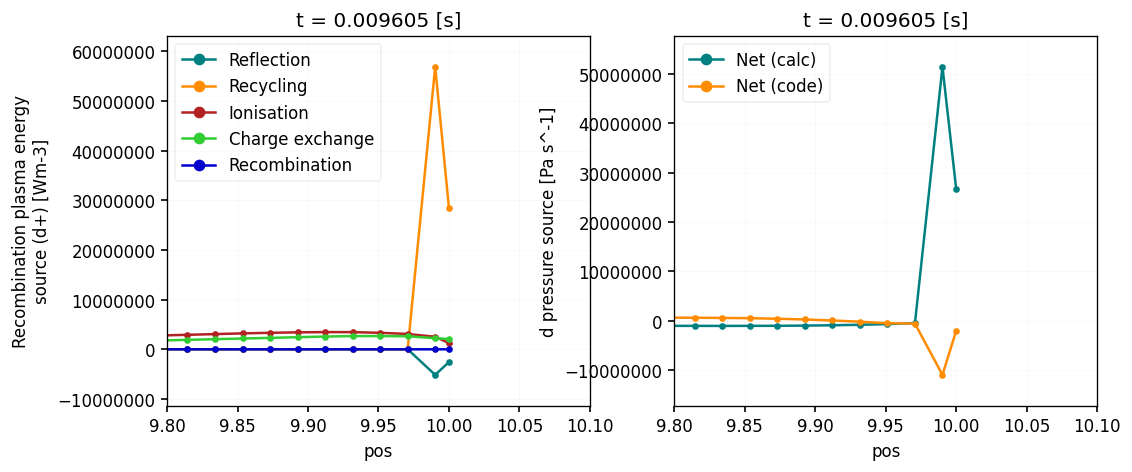

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

# for case in cases:
case = "frec"
ds = cases[case].isel(t=-1, pos = slice(2,-1))
m = ds.metadata
ms = 3
ax = axes[0]
ds["Ed_target_refl"].plot(ax = ax, label = "Reflection", marker = "o", ms = 3)
ds["Ed_target_recycle"].plot(ax = ax, label = "Recycling", marker = "o", ms = 3)
(ds["Ed+_iz"]).plot(ax = ax, label = "Ionisation", marker = "o", ms = 3)
(ds["Edd+_cx"]).plot(ax = ax, label = "Charge exchange", marker = "o", ms = 3)
(ds["Ed+_rec"]*-1).plot(ax = ax, label = "Recombination", marker = "o", ms = 3)

ax = axes[1]
calc = ds["Ed_target_refl"] + ds["Ed_target_recycle"] + ds["Ed+_iz"]*-1 + ds["Edd+_cx"] + (ds["Ed+_rec"]*-1)
spnorm = constants("q_e") * m["Nnorm"] * m["Tnorm"] * m["Omega_ci"]
calc.plot(ax = ax, label = "Net (calc)", marker = "o", ms = 3)
(ds["SPd"]*3/2*spnorm).plot(ax=ax, label = "Net (code)", marker = "o", ms = 3)

for ax in axes:
    ax.legend()
    ax.set_xlim(9.8,10.1)

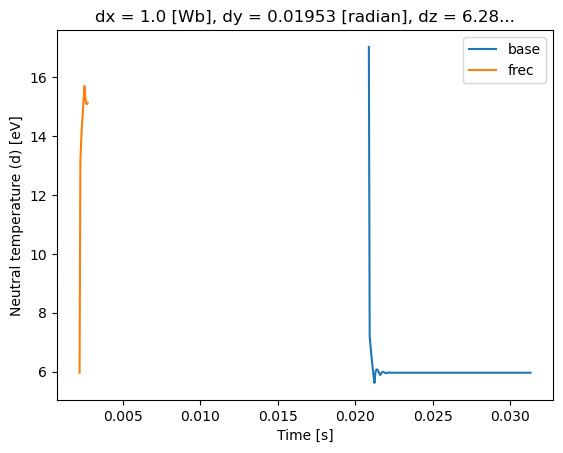

In [10]:
fig, ax = plt.subplots()

for case in cases:
    ds = cases[case].isel(pos=-3)
    ds["Td"].plot(ax = ax, label = case)
    
ax.legend()

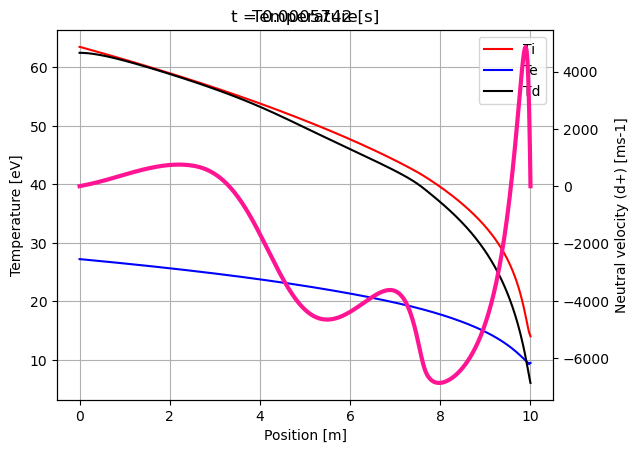

In [10]:
ds = cases["frec"].isel(t=-1, pos = slice(1,-1))  # Take out guard cells

fig, ax = plt.subplots()
ds["Td+"].plot(ax = ax, label = "Ti", ls = "-", c = "r")
ds["Te"].plot(ax = ax, label = "Te", ls = "-", c = "b")
ds["Td"].plot(ax = ax, label = "Td", ls = "-", c = "k")

ax2 = ax.twinx()
# ds["Fdd+_cx"].plot(ax = ax2, label = "Fcx", ls = "-", lw = 3, c = "deeppink")
ds["Vd"].plot(ax = ax2, label = "Fcx", ls = "-", lw = 3, c = "deeppink")

# ax2.set_yscale("log")
ax.legend()
ax.set_xlabel("Position [m]")
ax.set_ylabel("Temperature [eV]")
ax.set_title("Temperature")
ax.grid()

# 1D example case verification

In [ ]:
cases = {}
cases["before"] = Load.case_1D(r"/ssd_scratch/hcases/fastrec/1d/1d_recycling_before", guard_replace = False).ds
cases["after"] = Load.case_1D(r"/ssd_scratch/hcases/fastrec/1d/1d_recycling_after", guard_replace = False, squeeze = True).ds
# cases["sheathtest"] = Load.case_1D(r"/ssd_scratch/hcases/fastrec/1d/fr1d_5_sheath_hbalance_test", guard_replace = False).ds

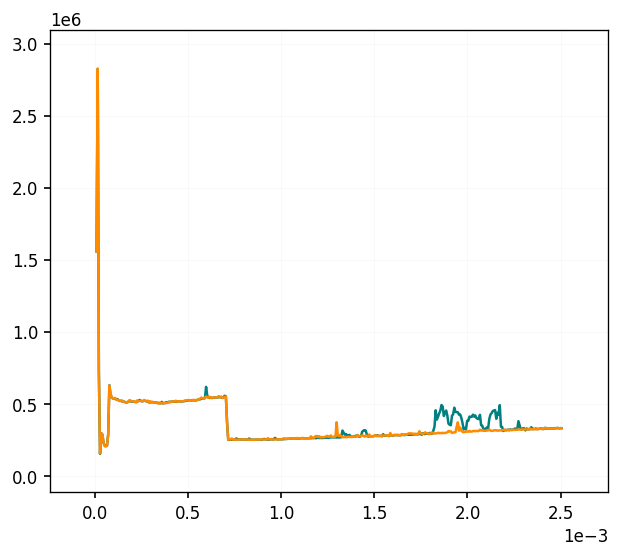

In [ ]:
fig, ax = plt.subplots()

for name in cases:
    ds = cases[name]
    wtime = ds["wtime"].values
    stime = np.diff(ds["t"].values, prepend = ds["t"].values[0]*0.99)
    wtime_per_stime = wtime/stime
    ax.plot(ds["t"].values, wtime_per_stime, label = name)

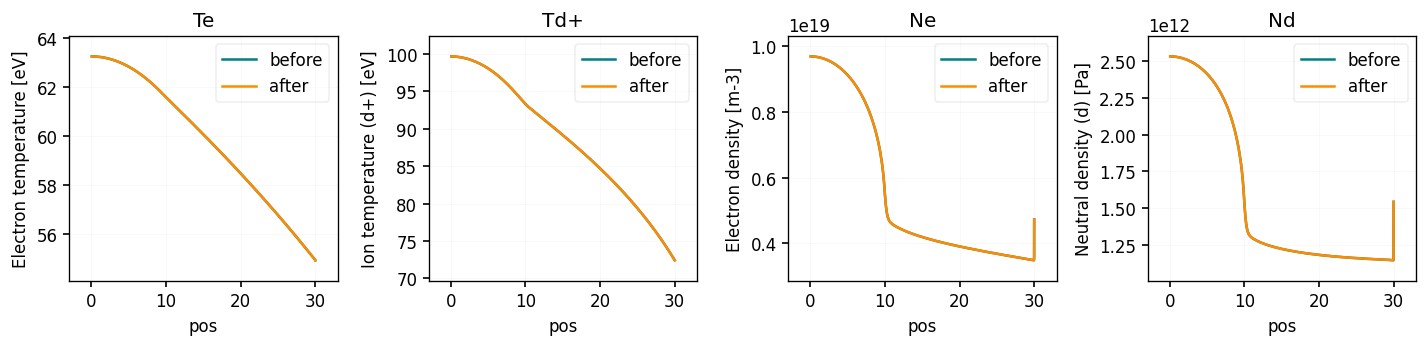

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(12,3), dpi = 120)

params = ["Te", "Td+", "Ne", "Nd"]

for name in cases:
    ds = cases[name].isel(t=-1, pos = slice(2,-2))
    
    for i, param in enumerate(params):
        ax = axes[i]
        ds[param].plot(ax = ax, label = name)
        ax.set_title(param)
        ax.legend()
    
fig.tight_layout()